In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite",echo = False)

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [12]:
columns = inspector.get_columns('station')
for cl in columns:
    print(cl['name'], cl['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
engine.execute('SELECT * FROM station').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

# Exploratory Climate Analysis

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

#session.query(func.count(Measurement.date)).all()

last_data_point = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

last_data_point

# session.query(func.extract(Topic.date_created, 'year'))

('2017-08-23')

In [15]:

year_ago = dt.date(2017,8,23) - dt.timedelta(days= 365)
print(year_ago)


2016-08-23


In [16]:
# Perform a query to retrieve the data and precipitation scores
# sel = [Measurement.date, 
#        func.avg(Measurement.prcp)]
# year_prcp = session.query(*sel).\

year_prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago, Measurement.prcp != None).\
    order_by(Measurement.date).all()
#     group_by(Measurement.date).\
    

In [17]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
df = pd.DataFrame(year_prcp, columns=['Date', 'Precipitation'])
df.set_index('Date', inplace=True)
df.head()



,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79


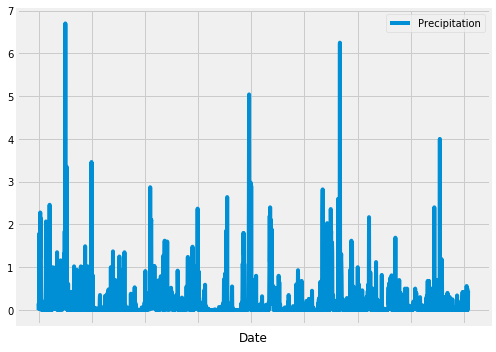

In [54]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(figsize=(7,5))
plt.tight_layout()
plt.savefig('Images/Precipitation.png')

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [20]:
# Design a query to show how many stations are available in this dataset?

#session.query(Measurement.station).group_by(Measurement.station).count()
session.query(Measurement.station).distinct().count()
               
#session.query(func.count(Station.station)).all()

9

In [21]:
#session.query(func.count(Measurement.station)).all()

In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station,func.count(Measurement.station)).\
                               group_by(Measurement.station).\
                               order_by(func.count(Measurement.station).desc()).all()
active_stations

# session.query(Invoices.BillingCountry, func.sum(Invoices.Total)).\
#     group_by(Invoices.BillingCountry).\
#     order_by(func.sum(Invoices.Total).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
result = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
                filter(Measurement.station == 'USC00519281').order_by(func.min(Measurement.tobs)).all()
result
#.order_by((Measurement.station).first()

[(54.0, 85.0, 71.66378066378067)]

In [24]:
# year_temp = session.query(Measurement.tobs).\
#     filter(Measurement.date >= year_ago, Measurement.station == high_temp_station).\
#     order_by(Measurement.tobs).all()

year_temp = session.query(Measurement.tobs).\
      filter(Measurement.date >= year_ago, Measurement.station == 'USC00519281').\
      order_by(Measurement.tobs).all()

In [25]:

df1 = pd.DataFrame(year_temp, columns=['Tobs'])
df1.head()


,Tobs
0,59.0
1,59.0
2,59.0
3,60.0
4,60.0


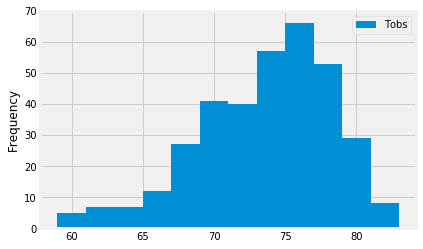

In [26]:
bins = 12
df1.plot.hist(year_temp,bins)
plt.ylim(0,70)
plt.savefig('Images/station-histogram.png')

In [27]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [28]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
prev_year_start = dt.date(2018,1,1) - dt.timedelta(days= 365)
# print(prev_year_start)
prev_year_end = prev_year_start + dt.timedelta(days = 5)
#print(prev_year_end)
calc_temp = calc_temps(prev_year_start,prev_year_end)
print(calc_temp)

[(62.0, 68.05714285714286, 74.0)]


In [29]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
ta_temp= list(np.ravel(calc_temp))
#ta_temp
tmin = ta_temp[0]
tmax = ta_temp[2]
temp_avg = ta_temp[1]


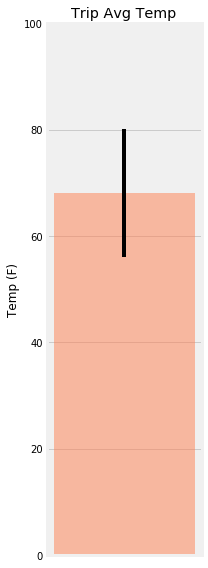

In [30]:
#fig, ax = plt.subplots()
# x = range(0,1)
# print(x)
plt.figure(figsize=(3,8))
plt.bar(1,temp_avg, color = 'coral',alpha = 0.5)
plt.errorbar(1,temp_avg, yerr=(tmax - tmin), color = 'k')
plt.ylim(0, 100)
plt.xticks([])
plt.title('Trip Avg Temp')
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.savefig('Images/temperature.png')



In [31]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall_station = session.query(Station.station, Station.name, Station.latitude,
                                 Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
        filter(Measurement.date >= prev_year_start, Measurement.date <= prev_year_end).\
        filter(Measurement.prcp != None).\
        filter(Station.station == Measurement.station).\
        group_by(Measurement.station).\
        order_by(func.sum(Measurement.prcp).desc()).all()
print(rainfall_station)

[('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.61), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.6), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.6), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.29), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.2), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)]


## Optional Challenge Assignment

In [32]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [34]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

start_date = dt.datetime.strptime('2018-01-01', "%Y-%m-%d")
end_date = dt.datetime.strptime('2018-01-07', "%Y-%m-%d")
#st_str_dt = start_date.strftime("%m-%d")
normals = []
dt_list = []

iter_date = start_date
while iter_date <= end_date:
    dt_list.append(iter_date)
    st_str_dt = iter_date.strftime("%m-%d")
    #print(st_str_dt)
    iter_date += dt.timedelta(1)
    normals.append(*daily_normals(st_str_dt))

#dt_list
normals


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [60]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df2 = pd.DataFrame(normals, columns=['tmin','tavg','tmax'])
df2['Date'] = pd.to_datetime(dt_list)
df2.set_index('Date', inplace=True)
df2

,tmin,tavg,tmax
Date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0
2018-01-06,61.0,68.964912,76.0
2018-01-07,57.0,68.543860,76.0


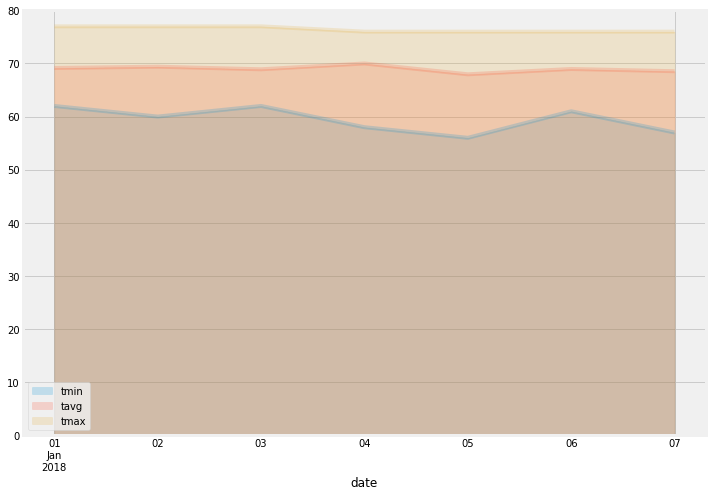

In [61]:
# Plot the daily normals as an area plot with `stacked=False`
df2.plot.area(stacked=False, alpha=0.2,figsize=(10,7))
plt.xlabel("date")
#plt.xticks(df2["Date"], rotation=45)
plt.ylim(0, 80)
plt.tight_layout()
plt.savefig('Images/daily_normals.png')
